# Preparing the environment

In [1]:
# !pip install cloud-tpu-client==0.10 # Per la TPU

In [2]:
# # Per TPU
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

# # imports pytorch
# import torch

# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

In [3]:
!git clone --recurse-submodules https://github.com/Enri-gin/DeepL_PoliTO.git

Cloning into 'DeepL_PoliTO'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 274 (delta 127), reused 202 (delta 63), pack-reused 0
Receiving objects: 100% (274/274), 28.72 MiB | 6.11 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Submodule 'DownloadVWW' (https://github.com/Enri-gin/MLandDL_polito.git) registered for path 'DownloadVWW'
Cloning into '/content/DeepL_PoliTO/DownloadVWW'...
remote: Enumerating objects: 95, done.        
remote: Counting objects: 100% (95/95), done.        
remote: Compressing objects: 100% (54/54), done.        
remote: Total 95 (delta 38), reused 83 (delta 37), pack-reused 0        
Receiving objects: 100% (95/95), 2.00 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Submodule path 'DownloadVWW': checked out '5558492fe48e8046efb4f68c9c0fc0944d8e06eb'


In [4]:
cd DeepL_PoliTO/

/content/DeepL_PoliTO


In [5]:
%run load_data.py

Folder corrente /content/DeepL_PoliTO
--COCO dataset scaricato
--contenuti da train2014/val2014 copiati in all2014
--Fatto lo split tra train e val
--Create le annotation


In [6]:
!pip install pyvww
!pip install thop

In [7]:
# !pip install timm

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
import matplotlib.pyplot as plt
import pyvww
import time
import os
import copy
import json
from Building_utils.model_by_blocks import ModelByBlocks
from Building_utils.train_model import train_model
from Genetic.utils import *

In [9]:
from NASWOT import compute_naswot_score
from zero_cost_nas.foresight.pruners.predictive import find_measures

In [10]:
import warnings
import time
import gc
import random
from google.colab import files

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
gamma = 0.1
num_epochs = 16
step_size = int(num_epochs/2)
lr = 0.05
momentum = 0.9
weight_decay = 1e-6
criterion = nn.CrossEntropyLoss()

num_classes = 2
measure_names = ['synflow']
n_batches = 2


# Compute mean and std per channel

In [ ]:
import torch

transform = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor(),
    ])

batch_size = 16
train_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="DownloadVWW/scripts/all2014",
                    annFile="DownloadVWW/scripts/annotations/instances_train.json",
                    transform=transform)

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
cnt = 0
fst_moment = torch.empty(3)
snd_moment = torch.empty(3)

for images, _ in dataloader_train:
    b, c, h, w = images.shape
    nb_pixels = b * h * w
    sum_ = torch.sum(images, dim=[0, 2, 3])
    sum_of_square = torch.sum(images ** 2,
                              dim=[0, 2, 3])
    fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
    snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
    cnt += nb_pixels

mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4701, 0.4468, 0.4075])
Std: tensor([0.2617, 0.2573, 0.2734])


The values of mean and std per channel are:

mean = [0.4701, 0.4468, 0.4075]

std = [0.2617, 0.2573, 0.2734]

# Load the data

In [13]:
mean = [0.4701, 0.4468, 0.4075]
std = [0.2617, 0.2573, 0.2734]

dim_image = 96

transform_test = T.Compose([
    T.Resize((dim_image, dim_image)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

transform_train = T.Compose([
    T.Resize((dim_image, dim_image)),
    T.RandAugment(num_ops=2, magnitude=8),
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="DownloadVWW/scripts/all2014",
                    annFile="DownloadVWW/scripts/annotations/instances_train.json",
                    transform=transform_train)

val_dataset = pyvww.pytorch.VisualWakeWordsClassification(root="DownloadVWW/scripts/all2014",
                    annFile="DownloadVWW/scripts/annotations/instances_val.json",
                    transform=transform_test)

loading annotations into memory...
Done (t=4.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [14]:
# Creating dataloaders for testing and validation
batch_size = 64
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': dataloader_train, 'val': dataloader_val}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Model by hands

In [ ]:
hand_model = ModelByBlocks([['c', 32, 3, 4, 1], ['c', 32, 3, 3, 2],
                              ['c', 64, 5, 3, 2], ['c', 64, 5, 2, 2],
                              ['i', 128, 3, 3, 1], ['i', 128, 3, 2, 2],
                              ['c', 128, 5, 3, 2], ['i', 256, 3, 3, 1],
                              ['i', 256, 3, 2, 1], ['i', 256, 5, 4, 1]])

macs, n_param = get_macs_and_params(hand_model, [1, 3, 96, 96])

print(f'model by hands has {n_param} parameters and {macs*2} FLOPs')

optimizer = optim.SGD(hand_model.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
hand_model = hand_model.to(device)
fitted_hand_model, hand_model_stats = train_model(hand_model, dataloaders, dataset_sizes, criterion, optimizer,
                                step_lr_scheduler, device=device, num_epochs=num_epochs)

torch.save(fitted_hand_model.state_dict(), './hand_model.pth')

with open('hand_model_stats.json', 'w') as json_file:
    json.dump(hand_model_stats, json_file)

files.download('hand_model_stats.json')
files.download('hand_model.pth')


model by hands has 2020950.0 parameters and 186414464.0 FLOPs
Epoch 1/16
----------
train Loss: 0.6860 Acc: 0.5516
val Loss: 0.6723 Acc: 0.5746
Epoch training time: 14m 39s

Epoch 2/16
----------
train Loss: 0.6685 Acc: 0.5930
val Loss: 0.6585 Acc: 0.6134
Epoch training time: 14m 29s

Epoch 3/16
----------
train Loss: 0.6522 Acc: 0.6187
val Loss: 0.6677 Acc: 0.6013
Epoch training time: 14m 30s

Epoch 4/16
----------
train Loss: 0.6406 Acc: 0.6314
val Loss: 0.6340 Acc: 0.6425
Epoch training time: 14m 29s

Epoch 5/16
----------
train Loss: 0.6327 Acc: 0.6405
val Loss: 0.6178 Acc: 0.6570
Epoch training time: 14m 30s

Epoch 6/16
----------
train Loss: 0.6255 Acc: 0.6496
val Loss: 0.6187 Acc: 0.6595
Epoch training time: 14m 30s

Epoch 7/16
----------
train Loss: 0.6154 Acc: 0.6598
val Loss: 0.6040 Acc: 0.6734
Epoch training time: 14m 25s

Epoch 8/16
----------
train Loss: 0.6047 Acc: 0.6713
val Loss: 0.6065 Acc: 0.6814
Epoch training time: 14m 22s

Epoch 9/16
----------
train Loss: 0.5763 A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

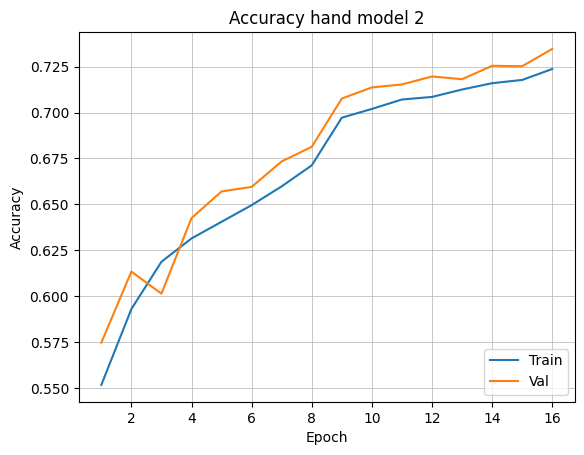

In [ ]:
z = range(1, num_epochs+1)
plt.plot(z, hand_model_stats['Training Accuracy'], label='Train')
plt.plot(z, hand_model_stats['Validation Accuracy'], label='Val')

# Dai un nome agli assi
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.grid(linewidth=0.5)
plt.title('Accuracy hand model')

# Visualizza il grafico
plt.show()

# Compute probabilities

In [ ]:
geometric_samples = []
probs = []
max_n_blocks = 12

for n_blocks in range(1, max_n_blocks+1):
  print(f"{n_blocks}/{max_n_blocks}")
  for _ in range(200):
    count = 1
    modello_a_caso = generate_random_list_of_lists(1, n_blocks)[0]
    mod_caso = ModelByBlocks(modello_a_caso)
    while not respect_constraints(mod_caso):
      modello_a_caso = generate_random_list_of_lists(1, n_blocks)[0]
      mod_caso = ModelByBlocks(modello_a_caso)
      count += 1
    geometric_samples.append(count)
  mean_geo_samples = sum(geometric_samples)/len(geometric_samples)
  prob = 1/mean_geo_samples
  probs.append(prob)


# print(f"Probability of accepting the architecture is: {prob*100:.3f}%")

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


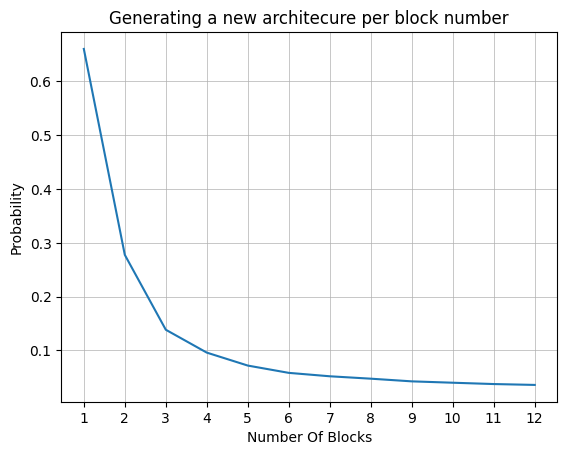

In [ ]:
z = np.arange(1, max_n_blocks+1)
plt.plot(z, probs)
plt.xticks(z)
plt.xlabel('Number Of Blocks')
plt.ylabel('Probability')
plt.grid(linewidth=0.5)
plt.title('Generating a new architecure per block number')
plt.show()


In [ ]:
print(probs)

[0.6600660066006601, 0.2775850104094379, 0.13850415512465375, 0.09603841536614646, 0.07197869430648528, 0.058428279287175, 0.05209302325581395, 0.047633224173861274, 0.04265706092850203, 0.040125995626266474, 0.03766349380264329, 0.03603820049252207]


# Random Search

## Generate search space

In [ ]:
N_SEARCH = 500
seed_value = 42
MAX_PARAMS = 2_500_000
MAX_FLOPS = 200_000_000
n_blocks = 10
dim_image = 96

random_search = generate_random_list_of_lists(N_SEARCH, n_blocks, seed=seed_value)
times_rejected = []

# Disabilita tutti i messaggi di avviso
warnings.filterwarnings("ignore")

print("Progression in percentage:")

for i in range(N_SEARCH):

  percent = (i / (N_SEARCH - 1)) * 100
  print(f"\r{percent:.2f}%", end="")
  time.sleep(0.001)  # Aggiungi un ritardo per simulare l'aggiornamento della barra

  random_model = ModelByBlocks(random_search[i])
  macs, params = get_macs_and_params(random_model, [1, 3, 96, 96])

  count = 0

  if params > MAX_PARAMS or macs*2 > MAX_FLOPS: # If the model that we just created overcomes the costraints:
    flag_to_replace = 0
    while flag_to_replace == 0:
      seed_value = seed_value + 1
      fictional_pop = generate_random_list_of_lists(1, n_blocks, seed=seed_value)
      model_to_replace = ModelByBlocks(fictional_pop[0])
      if respect_constraints(model_to_replace):
        random_search[i] = fictional_pop[0]
        flag_to_replace = 1
      else:
        count += 1
      model_to_replace.cpu()
      del model_to_replace
      gc.collect()
      torch.cuda.empty_cache()

  times_rejected.append(count)
  random_model.cpu()
  del random_model
  gc.collect()
  torch.cuda.empty_cache()

print()  # Vai a capo dopo aver completato la progressione
print(f"Average rejection rate = {sum(times_rejected) / len(times_rejected)}")

# Riabilita i messaggi di avviso
warnings.resetwarnings()

## Rating the models in searching space

In [ ]:
x, target = next(iter(dataloader_train))
score_random_nas = []
score_random_syn = []

# Disabilita tutti i messaggi di avviso
warnings.filterwarnings("ignore")

print("Progression in percentage:")
for i in range(N_SEARCH):
  percent = (i / (N_SEARCH - 1)) * 100
  print(f"\r{percent:.2f}%", end="")
  time.sleep(0.001)  # Aggiungi un ritardo per simulare l'aggiornamento della barra

  model = ModelByBlocks(random_search[i])

  score_nas = compute_naswot_score(model, dataloader_train)

  measures = find_measures(model, dataloader_train, dataload_info=('random',batch_size, num_classes), device=device, measure_names=measure_names)
  score_syn = measures['synflow']

  if not respect_constraints(model):
    score_nas = 0
    score_syn = 0

  score_random_nas.append(score_nas)
  score_random_syn.append(score_syn)

  model.cpu()

  del model
  gc.collect()
  torch.cuda.empty_cache()

print()  # Vai a capo dopo aver completato la progressione

# Riabilita i messaggi di avviso
warnings.resetwarnings()

NN = 3
fitness_list, list_index = calculate_fitness(score_random_nas, score_random_syn, NN)

print('-- RANDOM SEARCH --')
for i in range(NN):
  print(f'The best {i+1}-th score is {round(fitness_list[list_index[i]],3)} of the {list_index[i]}-th model: {history[list_index[i]]}')

with open('history_random.json', 'w') as json_file:
    json.dump(random_search, json_file)

with open('naswot_random.json', 'w') as json_file:
    json.dump(score_random_nas, json_file)

with open('synflow_random.json', 'w') as json_file:
    json.dump(score_random_syn, json_file)

files.download('naswot_random.json')
files.download('synflow_random.json')
files.download('history_random.json')


## Evaluating best model of random search

In [ ]:
best_random_search = ModelByBlocks([['i', 48, 5, 4, 2], ['c', 72, 9, 4, 2],
                                    ['c', 126, 3, 1, 2], ['c', 58, 5, 1, 1],
                                    ['i', 206, 3, 5, 2], ['i', 40, 7, 5, 1],
                                    ['i', 104, 5, 5, 1], ['i', 194, 9, 3, 2],
                                    ['i', 70, 9, 4, 1], ['i', 46, 7, 4, 2]])

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(best_random_search.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
best_random_search = best_random_search.to(device)
fitted_best_random_search, best_random_search_stats = train_model(best_random_search, dataloaders, dataset_sizes, criterion, optimizer,
                                step_lr_scheduler, device=device, num_epochs=num_epochs)

torch.save(fitted_best_random_search.state_dict(), './best_random_search.pth')


In [ ]:
z = range(1, 17)
plt.plot(z, best_random_search_stats['Training Accuracy'], label='Train')
plt.plot(z, best_random_search_stats['Validation Accuracy'], label='Val')

# Dai un nome agli assi
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.grid(linewidth=0.5)
plt.title('Accuracy best model random search')

# Visualizza il grafico
plt.show()

# Genetic Algorithm


## Initialization

In [15]:
P = 50
C = 500
n_blocks = 10
S = 20 # sub-sample random
seed_value = 42

In [16]:
with open('Models/population/Initial_population.json') as f_json:
  initial_population = json.load(f_json)

In [17]:
history = [] # track all the architectures
for i in range(P):
  history.append(initial_population[i])

x, target = next(iter(dataloader_train))

In [ ]:
initial_flops = []
initial_params = []
score_initial_nas = []
score_initial_syn = []

for seq_block in initial_population:
  model = ModelByBlocks(seq_block)
  macs, params = get_macs_and_params(model, [1, 3, 96, 96])
  initial_flops.append(macs*2)
  initial_params.append(params)

  measures = find_measures(model, dataloader_train, dataload_info=('random', 2, 2), device=device, measure_names=['synflow'])
  score_initial_nas.append(compute_naswot_score(model, x, target, device))
  score_initial_syn.append(measures['synflow'])

point_sizes, _ = calculate_fitness(score_initial_nas, score_initial_syn, len(score_initial_syn))

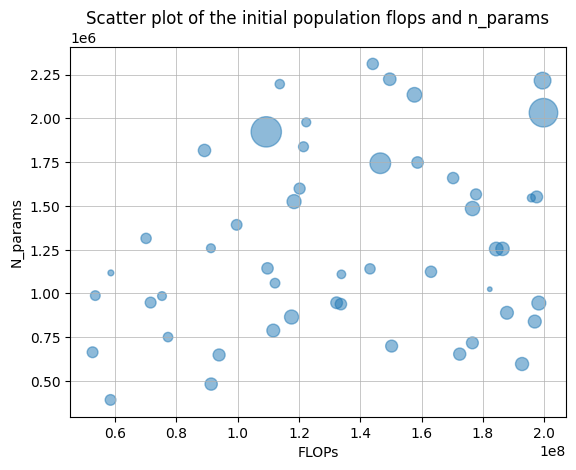

In [ ]:
# Point sizes are between 0 and 2, therefore the difference os not very notable
# That's why we are doing ^4 and x100
plt.scatter(initial_flops, initial_params, alpha=0.5, s=100*(np.array(point_sizes)**4))
plt.xlabel('FLOPs')
plt.ylabel('N_params')

plt.grid(linewidth=0.5)
plt.title('Scatter plot of the initial population flops and n_params')
plt.show()

## Actual Algorithm

To do the esperiment regarding the different number of blocks, just change the n_blocks variable

In [ ]:
n_blocks = 10
dim_image = 96
count_crossover = 0
num_classes = 2
measure_names = ['synflow']

# Disabilita tutti i messaggi di avviso
warnings.filterwarnings("ignore")

random_seed = 42
random.seed(random_seed)

print("Progression in percentage:")

for i in range(C):
  percent = (i / (C - 1)) * 100
  print(f"\r{percent:.2f}%", end="")
  time.sleep(0.001)  # Aggiungi un ritardo per simulare l'aggiornamento della barra

  sample_S = random.sample(history[-P:], S)
  score_sample_nas = []
  score_sample_syn = []

  for j in range(S):
    model = ModelByBlocks(sample_S[j])
    score_nas = compute_naswot_score(model, x, target, device)
    score_sample_nas.append(score_nas)

    measures = find_measures(model, dataloader_train,
                             dataload_info=('random', 2, num_classes),
                             device=device, measure_names=measure_names)
    score_syn = np.log(measures['synflow'])
    score_sample_syn.append(score_syn)

    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()

  NN = 2
  _, list_index = calculate_fitness(score_sample_nas, score_sample_syn, NN)
  parent1 = sample_S[list_index[0]]
  parent2 = sample_S[list_index[1]]

  parent_1 = copy.deepcopy(parent1)
  parent_2 = copy.deepcopy(parent2)

  crossover_1 = []
  crossover_1.extend(parent_1[:int(n_blocks/2)])
  crossover_1.extend(parent_2[-int(n_blocks/2):])

  group = (i - 1) // int(C/4)
  num_blocks_to_mutate = 4 - group

  mod_cross_1 = ModelByBlocks(crossover_1)
  if respect_constraints(mod_cross_1):
      history.append(crossover_1)
      count_crossover += 1
  mod_cross_1.cpu()
  del mod_cross_1
  gc.collect()
  torch.cuda.empty_cache()


  mutation_1 = mutate(parent_1, n_mutation = num_blocks_to_mutate)
  mod_mut_1 = ModelByBlocks(mutation_1)
  if respect_constraints(mod_mut_1):
    history.append(mutation_1)

  mod_mut_1.cpu()
  del mod_mut_1
  gc.collect()
  torch.cuda.empty_cache()


  mutation_2 = mutate(parent_2, n_mutation = num_blocks_to_mutate)
  mod_mut_2 = ModelByBlocks(mutation_2)
  if respect_constraints(mod_mut_2):
    history.append(mutation_2)

  mod_mut_2.cpu()
  del mod_mut_2
  gc.collect()
  torch.cuda.empty_cache()

print()  # Vai a capo dopo aver completato la progressione

# Riabilita i messaggi di avviso
warnings.resetwarnings()

In [ ]:
# Convert every list 10 blocchi in a tuple of tuples
tuple_data = [tuple(map(tuple, sublist)) for sublist in history]

# Use the set to delete copies
unique_history = set(tuple_data)

count_unique_lists = len(unique_history)

print("Number of unique lists:", count_unique_lists)

In [ ]:
unique_history = list(unique_history)
with open('history_genetic_new_P50_S20.json', 'w') as json_file:
    json.dump(unique_history, json_file)

In [ ]:
score_total_nas = []
score_total_syn = []

# Disabilita tutti i messaggi di avviso
warnings.filterwarnings("ignore")

print("Progression in percentage:")

for i in range(len(unique_history)):

  percent = (i / (len(unique_history) - 1)) * 100
  print(f"\r{percent:.2f}%", end="")
  time.sleep(0.001)  # Aggiungi un ritardo per simulare l'aggiornamento della barra

  model = ModelByBlocks(unique_history[i])
  score_nas = compute_naswot_score(model, x, target, device)
  score_total_nas.append(score_nas)

  measures = find_measures(model, dataloader_train, dataload_info=('random', 2, num_classes), device=device, measure_names=measure_names)
  score_syn = measures['synflow']
  score_total_syn.append(score_syn)

  model.cpu()

  del model
  gc.collect()
  torch.cuda.empty_cache()

print()

# Riabilita i messaggi di avviso
warnings.resetwarnings()

NN = 3
fitness_list_evo, list_index_evo = calculate_fitness(score_total_nas, score_total_syn, NN)

print('-- EVOLUTIONARY ALGORITHM P50 S20 --')
for i in range(NN):
  print(f'The best {i+1}-th score is {round(fitness_list_evo[list_index_evo[i]],3)} [NASWOT: {round(score_total_nas[list_index_evo[i]],3)}, Log-Synflow: {round(score_total_syn[list_index_evo[i]],3)}] of the {list_index_evo[i]}-th model:')
  print(f'{unique_history[list_index_evo[i]]}')

In [ ]:
with open('naswot_genetic_P50_S20.json', 'w') as json_file:
    json.dump(score_total_nas, json_file)

with open('synflow_genetic_P50_S20.json', 'w') as json_file:
    json.dump(score_total_syn, json_file)

files.download('naswot_genetic_P50_S20.json')
files.download('synflow_genetic_P50_S20.json')

## Testing the best model

In [ ]:
best_model_genetic = ModelByBlocks((('i', 56, 3, 4, 2), ('c', 64, 7, 5, 2),
                                    ('c', 80, 9, 4, 2), ('c', 136, 7, 5, 2),
                                    ('i', 80, 3, 5, 1), ('i', 96, 7, 4, 1),
                                    ('i', 232, 5, 3, 1), ('i', 192, 7, 2, 1),
                                    ('i', 176, 7, 2, 1), ('i', 176, 7, 5, 2)))

In [ ]:
optimizer = optim.SGD(best_model_genetic.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
best_model_genetic = best_model_genetic.to(device)
fitted_best_genetic, best_genetic_stats = train_model(best_model_genetic, dataloaders, dataset_sizes, criterion, optimizer,
                                step_lr_scheduler, device=device, num_epochs=num_epochs)

torch.save(fitted_best_genetic.state_dict(), './best_model_evo.pth')
with open('best_genetic_stats.json', 'w') as json_file:
    json.dump(best_genetic_stats, json_file)

files.download('best_model_evo.pth')
files.download('best_genetic_stats.json')

In [ ]:
z = range(1, num_epochs+1)
plt.plot(z, best_genetic_stats['Training Accuracy'], label='Train')
plt.plot(z, best_genetic_stats['Validation Accuracy'], label='Val')

# Dai un nome agli assi
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.grid(linewidth=0.5)
plt.title('Accuracy best model genetic')

# Visualizza il grafico
plt.show()

# Comparison with MobileNetV3

In [ ]:
# MobileNetV3 Small

model_mn3 = models.mobilenet_v3_small()
model_mn3 = model_mn3.to(device)

model_mn3.classifier[1].out_features = 2

param_mn3 = count_params(model_mn3)
macs_mn3, _ = get_macs_and_params(model_mn3, [1, 3, dim_image, dim_image])
print(f'MobileNetV3 Small has {param_mn3} parameters and {macs_mn3*2} FLOPs')

optimizer = optim.SGD(model_mn3.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
model_mn3, MN3_small_stats = train_model(model_mn3, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

# MobileNetV3 Large

model_mn3_large = models.mobilenet_v3_large()
model_mn3_large = model_mn3_large.to(device)

model_mn3_large.classifier[1].out_features = 2

param_mn3 = count_params(model_mn3_large)
macs_mn3, _ = get_macs_and_params(model_mn3_large, [1, 3, dim_image, dim_image])
print(f'MobileNetV3 Large has {param_mn3} parameters and {macs_mn3*2} FLOPs')

optimizer = optim.SGD(model_mn3_large.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
model_mn3_large, MN3_large_stats = train_model(model_mn3_large, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)